In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import import_ipynb
from rotation import rotation_matrix, unit_vector, angle_between, x_rotation, y_rotation, z_rotation

# for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, EditedNearestNeighbours, AllKNN

import csv
from csv import reader
import pickle
from collections import Counter
from matplotlib import pyplot

importing Jupyter notebook from rotation.ipynb


In [2]:
NUM_FEATURES = 3
NUM_JOINTS = 20
NUM_FRAMES = 16
FILE_NAME = '../train.csv'
test_FILE_NAME = '../test.csv'

In [92]:
dtf = pd.read_csv(FILE_NAME, header = None)
#dtf = dtf.set_index(dtf.columns[0])

dtf = dtf.sample(frac = 1)
X = dtf.iloc[:,:-1]
y = dtf.iloc[:,-1]

dtf_test = pd.read_csv(test_FILE_NAME, header = None)
#dtf_test = dtf_test.set_index(dtf_test.columns[0])

dtf_test = dtf_test.sample(frac = 1)
X_test = dtf_test.iloc[:,:]
X_test_index = dtf_test.iloc[:,0]

In [114]:
print(y)

6853    16
3254     6
579      2
846      2
4729     9
        ..
4124     8
2917     6
8833    34
5250    10
7390    19
Name: 961, Length: 9388, dtype: int64


In [4]:
def read_xyz(row):
    skeleton_data, label = read_skeleton(row)
    
    data = np.zeros((NUM_FRAMES, NUM_JOINTS, NUM_FEATURES))
    for m, i in enumerate(skeleton_data['frame_info']):
        for n, j in enumerate(i['joint_info']):
            feature_info = j['feature_info']
            data[m, n, :] = [feature_info['x'], feature_info['y'], feature_info['z']]

    data = data.transpose(2, 0, 1)
    return data, label

In [5]:
def read_skeleton(row):
    label = row[-1]
    #label = -1
    skeleton_data = {}
    skeleton_data['index'] = row[0]
    skeleton_data['num_frame'] = NUM_FRAMES
    skeleton_data['frame_info'] = []
    
    for frame in range(NUM_FRAMES):
        offset = NUM_JOINTS * NUM_FEATURES
        data_in_frame = row[frame*offset:(frame+1)*offset]
        frame_info = {}
        frame_info['num_joints'] = NUM_JOINTS
        frame_info['joint_info'] = []
        
        for feature in range(NUM_JOINTS):
            offset = NUM_FEATURES
            data_in_joint = data_in_frame[feature*offset:(feature+1)*offset]
            joint_info = {}
            joint_info['num_features'] = NUM_FEATURES
            joint_info['feature_info'] = {
                k: float(v)
                for k, v in zip(['x', 'y', 'z'], data_in_joint)
            }
            frame_info['joint_info'].append(joint_info)
                    
        skeleton_data['frame_info'].append(frame_info)
    return skeleton_data, label

In [6]:
def normalisation(data):
    N, C, T, V, M = data.shape
    s = np.transpose(data, [0, 4, 2, 3, 1])
    zaxis=[0, 1]
    xaxis=[8, 4]
    
    print('sub the center joint #1 (spine joint in ntu and neck joint in kinetics)')
    for i_s, skeleton in enumerate(tqdm(s)):
        if skeleton.sum() == 0:
            continue
        main_body_center = skeleton[0][:, 1:2, :].copy()
        for i_p, person in enumerate(skeleton):
            if person.sum() == 0:
                continue
            mask = (person.sum(-1) != 0).reshape(T, V, 1)
            s[i_s, i_p] = (s[i_s, i_p] - main_body_center) * mask

    print('parallel the bone between hip(jpt 0) and spine(jpt 1) of the first person to the z axis')
    for i_s, skeleton in enumerate(tqdm(s)):
        if skeleton.sum() == 0:
            continue
        joint_bottom = skeleton[0, 0, zaxis[0]]
        joint_top = skeleton[0, 0, zaxis[1]]
        axis = np.cross(joint_top - joint_bottom, [0, 0, 1])
        angle = angle_between(joint_top - joint_bottom, [0, 0, 1])
        matrix_z = rotation_matrix(axis, angle)
        for i_p, person in enumerate(skeleton):
            if person.sum() == 0:
                continue
            for i_f, frame in enumerate(person):
                if frame.sum() == 0:
                    continue
                for i_j, joint in enumerate(frame):
                    s[i_s, i_p, i_f, i_j] = np.dot(matrix_z, joint)

    print('parallel the bone between right shoulder(jpt 8) and left shoulder(jpt 4) of the first person to the x axis')
    for i_s, skeleton in enumerate(tqdm(s)):
        if skeleton.sum() == 0:
            continue
        joint_rshoulder = skeleton[0, 0, xaxis[0]]
        joint_lshoulder = skeleton[0, 0, xaxis[1]]
        axis = np.cross(joint_rshoulder - joint_lshoulder, [1, 0, 0])
        angle = angle_between(joint_rshoulder - joint_lshoulder, [1, 0, 0])
        matrix_x = rotation_matrix(axis, angle)
        for i_p, person in enumerate(skeleton):
            if person.sum() == 0:
                continue
            for i_f, frame in enumerate(person):
                if frame.sum() == 0:
                    continue
                for i_j, joint in enumerate(frame):
                    s[i_s, i_p, i_f, i_j] = np.dot(matrix_x, joint)

    data = np.transpose(s, [0, 4, 2, 3, 1])
    return data
    

In [102]:
X_train = X.set_index(X.columns[0])
X_test = X_test.set_index(X_test.columns[0])

In [85]:
# Stratified Train test split
sss = model_selection.StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=None)
# for train_index, test_index in sss.split(X, y):
#     # print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_test)

[[0.36972512 0.46423836 0.45197736 ... 0.48315768 0.54534249 0.41140175]
 [0.36430274 0.47990098 0.44385236 ... 0.49498812 0.55907656 0.39107712]
 [0.3644477  0.47518026 0.44947845 ... 0.47587249 0.54689263 0.41249393]
 ...
 [0.36607141 0.46506559 0.44994043 ... 0.47700852 0.54728341 0.41297345]
 [0.33113919 0.47240617 0.45907522 ... 0.47906649 0.54530576 0.4114598 ]
 [0.35829733 0.45490355 0.45376928 ... 0.48152269 0.54302455 0.41521557]]


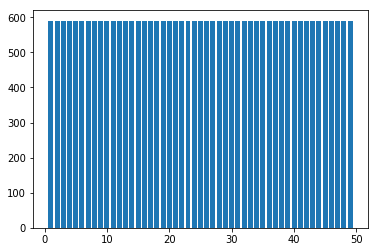

(28910, 960)
             1          2          3          4          5          6    \
0       1.070600   1.580000  -1.029700   0.302310   1.048000   0.058457   
1      -9.658200   6.238700 -17.618000   3.211300   8.067000   1.204400   
2      -9.746400  -9.441500   1.178100 -25.063000 -27.262000   8.604600   
3     -30.075000 -15.865000  26.639000 -13.412000 -16.740000  11.823000   
4       1.659200   0.725640  -8.068600  -1.220800   0.562950  -5.074300   
...          ...        ...        ...        ...        ...        ...   
28905   0.761103  -0.600478   0.681922   0.002354  -0.511082  -0.498532   
28906  -7.581420  -2.675716  -4.279593  -3.300752  -1.110229  -2.617007   
28907   0.677345   0.107477   0.097420   0.172338   0.116393   0.069284   
28908  -0.049747  -0.281398   0.342288  -0.697670  -0.239056  -0.608002   
28909   4.960533  -0.803019  -0.253782   1.010568  -0.297610  -0.217291   

             7          8          9          10   ...         951        952  \
0    

In [115]:
# smote = SMOTE(sampling_strategy='minority', random_state=42)
# x_smote, y_smote = smote.fit_resample(X, y)
# # fit predictor and target variable

# Try these below instead --- Jin Hong
#x_smote, y_smote = X_train, y
x_smote, y_smote = SMOTE(random_state=42).fit_resample(X_train, y)
#x_smote, y_smote = SMOTETomek(random_state=42).fit_resample(X_train, y)
#x_smote, y_smote = SMOTEENN(random_state=42).fit_resample(X_train, y)



# ------------------------ Divider ------------------------------#
# ------------- Manual downsample + SMOTETomek ------------------#

# strategy = Counter(y)
# for key, val in strategy.items():
#     if key < 11:
#         strategy[key] = 200
        
#     else:
#         strategy[key] = val

# x_rus, y_rus = RandomUnderSampler(sampling_strategy=strategy, random_state=42).fit_resample(X_train, y)
# x_smote, y_smote = SMOTETomek(sampling_strategy='all', random_state=42).fit_resample(x_rus, y_rus)

pyplot.bar(Counter(y_smote).keys(), Counter(y_smote).values())
pyplot.show()

print(x_smote.shape)
print(x_smote)

In [110]:
fp = np.zeros((len(x_smote), NUM_FEATURES, NUM_FRAMES, NUM_JOINTS, 1), dtype=np.float32) #construct a matrix, with num of data, num of features for each joint, num of frames, num of joints, num of people(always 1 in our case)
print(len(x_smote))
for i, row in enumerate(x_smote.to_numpy()):
    data, label = read_xyz(row)
    fp[i, :, :, :, 0] = data
#fp = normalisation(fp)
np.save('train_smote_custom.npy', fp)

9746


In [116]:
print(y_smote)

0        16
1         6
2         2
3         2
4         9
         ..
28905    49
28906    49
28907    49
28908    49
28909    49
Name: 961, Length: 28910, dtype: int64


In [112]:
labels = []
for i, row in enumerate(y_smote.values):
    labels.append(row)
with open('label_smote_custom.pkl', 'wb') as f:
    pickle.dump(labels, f)

In [ ]:
fp = np.zeros((len(X_test), NUM_FEATURES, NUM_FRAMES, NUM_JOINTS, 1), dtype=np.float32) #construct a matrix, with num of data, num of features for each joint, num of frames, num of joints, num of people(always 1 in our case)
for i, row in enumerate(X_test):
    data, label = read_xyz(row)
    fp[i, :, :, :, 0] = data
#fp = normalisation(fp)
np.save('test_minmax.npy', fp)

In [ ]:
labels = []
for i, row in enumerate(X_test_index):
    labels.append(row-1)
with open('label_test.pkl', 'wb') as f:
    pickle.dump(labels, f)

In [11]:
# fp = np.zeros((len(dtf), NUM_FEATURES, NUM_FRAMES, NUM_JOINTS, 1), dtype=np.float32)
#     #construct a matrix, with num of data, num of features for each joint, num of frames, num of joints, num of people(always 1 in our case)
# with open(FILE_NAME, 'r') as f:
#         csv_reader = reader(f)
#         labels = []
#         for i, row in enumerate(csv_reader):
#             data, label = read_xyz(row)
#             labels.append(int(label))
#             fp[i, :, :, :, 0] = data
#fp = normalisation(fp)
#np.save('train_data.npy', fp)
#np.save('test_data.npy', fp)

# with open('label.pkl', 'wb') as f:
#     pickle.dump(labels, f)

In [106]:
unpickled_df = pd.read_pickle("label_smote_all.pkl")
unpickled_df

[16,
 6,
 2,
 2,
 9,
 5,
 14,
 6,
 29,
 30,
 23,
 7,
 7,
 14,
 4,
 26,
 18,
 7,
 34,
 20,
 24,
 5,
 38,
 1,
 17,
 3,
 8,
 37,
 1,
 9,
 9,
 8,
 6,
 2,
 7,
 3,
 30,
 8,
 4,
 13,
 9,
 1,
 5,
 4,
 46,
 28,
 3,
 1,
 8,
 29,
 1,
 1,
 7,
 33,
 21,
 19,
 6,
 6,
 18,
 4,
 16,
 2,
 9,
 7,
 7,
 19,
 2,
 29,
 26,
 8,
 2,
 4,
 6,
 10,
 21,
 7,
 4,
 10,
 3,
 25,
 7,
 20,
 8,
 2,
 1,
 17,
 10,
 12,
 17,
 12,
 2,
 6,
 5,
 17,
 19,
 9,
 21,
 4,
 18,
 13,
 29,
 5,
 17,
 5,
 4,
 3,
 7,
 2,
 24,
 6,
 7,
 4,
 5,
 3,
 9,
 8,
 3,
 9,
 38,
 5,
 8,
 26,
 5,
 17,
 8,
 24,
 19,
 10,
 21,
 17,
 3,
 11,
 16,
 5,
 7,
 19,
 1,
 23,
 8,
 7,
 2,
 13,
 41,
 8,
 25,
 12,
 38,
 6,
 19,
 2,
 8,
 18,
 18,
 7,
 18,
 19,
 8,
 5,
 1,
 1,
 3,
 28,
 10,
 1,
 6,
 6,
 6,
 8,
 16,
 9,
 22,
 9,
 8,
 36,
 1,
 34,
 46,
 20,
 12,
 4,
 5,
 10,
 39,
 6,
 27,
 5,
 1,
 8,
 24,
 8,
 9,
 4,
 4,
 12,
 2,
 47,
 12,
 10,
 11,
 16,
 6,
 20,
 15,
 4,
 5,
 25,
 4,
 3,
 48,
 2,
 30,
 2,
 7,
 2,
 8,
 10,
 12,
 1,
 2,
 6,
 49,
 1,
 47,
 4,
 5,
 9,
 